# CAR-T CD8 T cell Analysis

In [21]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pickle as pkl
pd.set_option('display.max_columns', 500)
%matplotlib inline

In [22]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.9-py3.8.egg')
import memento

In [23]:
data_path = '/data_volume/memento/cart/'

### Read the data

In [24]:
adata = sc.read(data_path + 'CD8_CART_counts')

In [25]:
adata.obs['response_binary'] = (adata.obs['response']=='DR').astype(int)

In [26]:
# adata.obs['response_binary'] = np.random.choice(adata.obs['response_binary'], adata.shape[0])

In [27]:
filtered_patients = adata.obs['patient'].value_counts()
filtered_patients = filtered_patients[filtered_patients > 1000].index.tolist()

In [28]:
adata = adata[adata.obs.patient.isin(filtered_patients)].copy().copy()

### Setup memento

In [29]:
adata.obs['capture_rate'] = 0.1
memento.setup_memento(adata, q_column='capture_rate', trim_percent=0.1, filter_mean_thresh=0.001, estimator_type='mean_only')

In [30]:
adata.obs['patient-group'] = adata.obs['patient'].astype(str) + '^' + adata.obs['response_binary'].astype(str)

In [32]:
adata.obs['patient-group'] = np.random.choice(adata.obs['patient-group'], adata.shape[0], replace=False)
adata.obs['patient'] = adata.obs['patient-group'].str.split('^').str[0]
adata.obs['response_binary'] = adata.obs['patient-group'].str.split('^').str[1].astype(int)

In [33]:
memento.create_groups(adata, label_columns=['patient','response_binary'])
# memento.create_groups(adata, label_columns=['response_binary'])

In [34]:
memento.compute_1d_moments(adata, min_perc_group=.9)

### Setup hypothesis testing

Use the response variable as the treatment. Because the response variable is determined at the patient level, we must do hierarchical bootstrap to avoid inflation of P-values.

In [35]:
sample_meta = memento.get_groups(adata)

In [36]:
sample_meta

,patient,response_binary
sg^JCAR01-RR^0,JCAR01-RR,0
sg^JCAR08-GP^1,JCAR08-GP,1
sg^JCAR03-LR^1,JCAR03-LR,1
sg^bb2121-05-YM^1,bb2121-05-YM,1
sg^JCAR04-SS^0,JCAR04-SS,0
sg^JCAR09-MB^1,JCAR09-MB,1
sg^bb2121-05-HN^0,bb2121-05-HN,0


In [37]:
treatment = sample_meta[['response_binary']]

In [38]:
adata.shape

(75945, 12130)

### Differential mean expression testing

In [39]:
%env PYTHONWARNINGS=ignore::RuntimeWarning


memento.ht_1d_moments(
    adata, 
    covariate=pd.DataFrame(np.ones((sample_meta.shape[0], 1))),
    treatment=treatment,
    num_boot=5000, 
    verbose=1,
    num_cpus=14,
    resampling='bootstrap',
    approx=False,
    resample_rep=True)

env: PYTHONWARNINGS=ignore::RuntimeWarning


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    3.8s
[Parallel(n_jobs=14)]: Done 172 tasks      | elapsed:    7.2s
[Parallel(n_jobs=14)]: Done 422 tasks      | elapsed:   13.8s
[Parallel(n_jobs=14)]: Done 772 tasks      | elapsed:   22.1s
[Parallel(n_jobs=14)]: Done 1222 tasks      | elapsed:   33.6s
[Parallel(n_jobs=14)]: Done 1772 tasks      | elapsed:   47.7s
[Parallel(n_jobs=14)]: Done 2422 tasks      | elapsed:  1.1min
[Parallel(n_jobs=14)]: Done 3172 tasks      | elapsed:  1.4min
[Parallel(n_jobs=14)]: Done 4022 tasks      | elapsed:  1.7min
[Parallel(n_jobs=14)]: Done 4972 tasks      | elapsed:  2.1min
[Parallel(n_jobs=14)]: Done 6022 tasks      | elapsed:  2.6min
[Parallel(n_jobs=14)]: Done 7172 tasks      | elapsed:  3.0min
[Parallel(n_jobs=14)]: Done 8422 tasks      | elapsed:  3.6min
[Parallel(n_jobs=14)]: Done 9772 tasks      | elapsed:  4.1min
[Parallel(n_jobs=14)]: Done 11222 tasks      

In [43]:
result = memento.get_1d_ht_result(adata)

(array([ 220.,  602.,  953., 1164., 1326., 1470., 1470., 1645., 1658.,
        1622.]),
 array([0.0237467 , 0.12133132, 0.21891594, 0.31650057, 0.41408519,
        0.51166981, 0.60925443, 0.70683905, 0.80442367, 0.9020083 ,
        0.99959292]),
 <BarContainer object of 10 artists>)

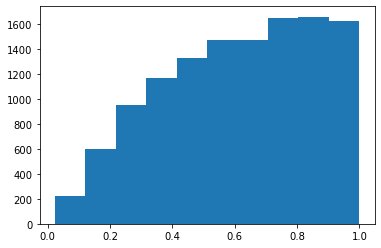

In [44]:
plt.hist(result['de_pval'])

In [45]:
result.head(5)

,gene,tx,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval
0,AL669831.5,response_binary,-0.000505,0.000927,0.551829,0.0,4.881513e-16,0.999797
1,LINC00115,response_binary,0.000933,0.001291,0.427321,0.0,4.880456e-16,0.998779
2,NOC2L,response_binary,0.003225,0.003937,0.359241,0.0,4.979043e-16,1.000000
3,KLHL17,response_binary,0.001076,0.001177,0.309461,0.0,4.846274e-16,0.999593
4,PLEKHN1,response_binary,0.000397,0.000818,0.583316,0.0,4.851991e-16,0.999591
